In [114]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
data = pd.read_csv('~/Desktop/project2/data.csv')
data.shape

(101766, 50)

In [115]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')


In [116]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,60-70,70-80,80-90,80-90,60-70,70-80,80-90,70-80,80-90,70-80
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


# Missing Values
Want to drop medical_specialty,weight ,payer_code for sure

In [117]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [118]:
data['readmitted_urgent'] = (data['readmitted'] == 'smaller_than_30').astype(int)

In [119]:

#Create new variable 'readmitted_yes' for binary classification
data['readmitted_yes']= (data['readmitted'] == 'greater_than_30').astype(int) +  (data['readmitted'] == 'smaller_than_30').astype(int) 

In [120]:
data.groupby(["readmitted_yes"])['readmitted_yes'].count()

readmitted_yes
0    54864
1    46902
Name: readmitted_yes, dtype: int64

In [121]:
data.groupby(["readmitted_urgent"])['readmitted_urgent'].count()

readmitted_urgent
0    90409
1    11357
Name: readmitted_urgent, dtype: int64

In [122]:
# Encode change column, gender, diabetesMed column
# ch to Yes to 1, No to 1 
# gender: Male to 1, Female to 0
# DiabetesMed: Yed to 1, No to 0

In [123]:
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)
data['gender'] = data['gender'].replace('Male', 1)
data['gender'] = data['gender'].replace('Female', 0)
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)


In [124]:
# there are 24 features of medicine,which indicates whether the drug 
# was prescribed or there was a change in the dosage
# Possible values: “up” if the dosage was increased during the encounter, 
# “down” if the dosage was decreased, “steady” if the dosage did not change,
# and “no” if the drug was not prescribed

meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
        'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [125]:
# Encode Up to 3, steady to 2, down to 1, no to 0
for col in meds:
    data[col] = data[col].replace('No', 0)
    data[col] = data[col].replace('Steady', 2)
    data[col] = data[col].replace('Up', 3)
    data[col] = data[col].replace('Down', 1)

In [126]:
data.groupby(['age'])['age'].count()

age
0-10        161
10-20       691
20-30      1657
30-40      3775
40-50      9685
50-60     17256
60-70     22483
70-80     26068
80-90     17197
90-100     2793
Name: age, dtype: int64

In [127]:

# Convert age to numerical, take the mid point of each interval, 5,15,25, etc

data['age'] = data['age'].replace('0-10', 5)
data['age'] = data['age'].replace('10-20', 15)
data['age'] = data['age'].replace('20-30', 25)
data['age'] = data['age'].replace('30-40', 35)
data['age'] = data['age'].replace('40-50', 45)
data['age'] = data['age'].replace('50-60', 55)
data['age'] = data['age'].replace('60-70', 65)
data['age'] = data['age'].replace('70-80', 75)
data['age'] = data['age'].replace('80-90', 85)
data['age'] = data['age'].replace('90-100', 95)

In [128]:
# convert examide and citoglipton to binary
data.groupby(['examide'])['examide'].count()
data.groupby(['citoglipton'])['citoglipton'].count()
# No need, all values are NO, just drop them

citoglipton
No    101766
Name: citoglipton, dtype: int64

In [129]:
# Drop payer_code, weight, medical_specialty, readmitted, examide, citoglipton
del_columns = ['weight', 'payer_code', 'medical_specialty','examide','citoglipton','readmitted']
data.drop(del_columns, inplace=True, axis=1)

Drop multiple encounters for one patient, only keep the first encounter.

In [130]:
id_list = []
encounter_list = []
for index, row in data.iterrows():
    if row['patient_nbr'] not in id_list:
        id_list.append(row['patient_nbr'])
        encounter_list.append(index)


In [131]:
df = data.iloc[list(encounter_list),:]

In [132]:
del_col = ["encounter_id","patient_nbr"]
df.drop(del_col, inplace=True, axis=1)

Drop observations that are discharged to Hospice facilities

In [133]:
df.drop(df[df.discharge_disposition_id == 11].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 13].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 14].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 19].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 20].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 21].index, inplace=True)

In [134]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [135]:
# Recode diag1, diag2, diag3

df.loc[df['diag_1'].str.contains('V'), ['diag_1']] = "SUPPLEMENTARY"
df.loc[df['diag_2'].str.contains('V'), ['diag_2']] = "SUPPLEMENTARY"
df.loc[df['diag_3'].str.contains('V'), ['diag_3']] = "SUPPLEMENTARY"

df.loc[df['diag_1'].str.contains('E'), ['diag_1']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_2'].str.contains('E'), ['diag_2']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_3'].str.contains('E'), ['diag_3']] = "SUPPLEMENTARY_EXTERNAL"

df['diag_1'] = df['diag_1'].replace('?', "NONE")
df['diag_2'] = df['diag_2'].replace('?', "NONE")
df['diag_3'] = df['diag_3'].replace('?', "NONE")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Recode diagnosis columns

In [136]:
# Helper function to convert str to float
def change_to_num(col):
    res = []
    for i in col:
        if i not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
            res.append(float(i))
        else:
            res.append(i)
    return res
        

In [137]:
df['diag_1'] = change_to_num(df['diag_1'])
df['diag_2'] = change_to_num(df['diag_2'])
df['diag_3'] = change_to_num(df['diag_3'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [138]:
new_diag_1 = []
for index, row in df.iterrows():
    if row['diag_1'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_1'] >= 1 and row['diag_1'] <= 139):
            new_diag_1.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
            new_diag_1.append("NEOPLASMS")
        elif (row['diag_1'] >= 240 and row['diag_1'] <= 279):
            new_diag_1.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_1'] >= 280 and row['diag_1'] <= 289):
            new_diag_1.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_1'] >= 290 and row['diag_1'] <= 319):
            new_diag_1.append("MENTAL_DISORDER")
        elif (row['diag_1'] >= 320 and row['diag_1'] <= 389):
            new_diag_1.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_1'] >= 390 and row['diag_1'] <= 459):
            new_diag_1.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 460 and row['diag_1'] <= 519):
            new_diag_1.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 520 and row['diag_1'] <= 579):
            new_diag_1.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 580 and row['diag_1'] <= 629):
            new_diag_1.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 630 and row['diag_1'] <= 679):
            new_diag_1.append("PREGNANCY")
        elif (row['diag_1'] >= 680 and row['diag_1'] <= 709):
            new_diag_1.append("SKIN_DISEASE")
        elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
            new_diag_1.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 740 and row['diag_1'] <= 759):
            new_diag_1.append("CONGENITAL_ANOMALIES")
        elif (row['diag_1'] >= 760 and row['diag_1'] <= 779):
            new_diag_1.append("PERINATAL_PERIOD")
        elif (row['diag_1'] >= 780 and row['diag_1'] <= 799):
            new_diag_1.append("ILL_DEFINED_COND")
        elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
            new_diag_1.append("INJURY_POISONING")
    else:
        new_diag_1.append(row['diag_1'])


In [139]:
df['diag_1'] = pd.Series(new_diag_1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [140]:
new_diag_2 = []
for index, row in df.iterrows():
    if row['diag_2'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_2'] >= 1 and row['diag_2'] <= 139):
            new_diag_2.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_2'] >= 140 and row['diag_2'] <= 239):
            new_diag_2.append("NEOPLASMS")
        elif (row['diag_2'] >= 240 and row['diag_2'] <= 279):
            new_diag_2.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_2'] >= 280 and row['diag_2'] <= 289):
            new_diag_2.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_2'] >= 290 and row['diag_2'] <= 319):
            new_diag_2.append("MENTAL_DISORDER")
        elif (row['diag_2'] >= 320 and row['diag_2'] <= 389):
            new_diag_2.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_2'] >= 390 and row['diag_2'] <= 459):
            new_diag_2.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 460 and row['diag_2'] <= 519):
            new_diag_2.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 520 and row['diag_2'] <= 579):
            new_diag_2.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 580 and row['diag_2'] <= 629):
            new_diag_2.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 630 and row['diag_2'] <= 679):
            new_diag_2.append("PREGNANCY")
        elif (row['diag_2'] >= 680 and row['diag_2'] <= 709):
            new_diag_2.append("SKIN_DISEASE")
        elif (row['diag_2'] >= 710 and row['diag_2'] <= 739):
            new_diag_2.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 740 and row['diag_2'] <= 759):
            new_diag_2.append("CONGENITAL_ANOMALIES")
        elif (row['diag_2'] >= 760 and row['diag_2'] <= 779):
            new_diag_2.append("PERINATAL_PERIOD")
        elif (row['diag_2'] >= 780 and row['diag_2'] <= 799):
            new_diag_2.append("ILL_DEFINED_COND")
        elif (row['diag_2'] >= 800 and row['diag_2'] <= 999):
            new_diag_2.append("INJURY_POISONING")
    else:
        new_diag_2.append(row['diag_2'])

df['diag_2'] = pd.Series(new_diag_2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [141]:
new_diag_3 = []
for index, row in df.iterrows():
    if row['diag_3'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_3'] >= 1 and row['diag_3'] <= 139):
            new_diag_3.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_3'] >= 140 and row['diag_3'] <= 239):
            new_diag_3.append("NEOPLASMS")
        elif (row['diag_3'] >= 240 and row['diag_3'] <= 279):
            new_diag_3.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_3'] >= 280 and row['diag_3'] <= 289):
            new_diag_3.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_3'] >= 290 and row['diag_3'] <= 319):
            new_diag_3.append("MENTAL_DISORDER")
        elif (row['diag_3'] >= 320 and row['diag_3'] <= 389):
            new_diag_3.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_3'] >= 390 and row['diag_3'] <= 459):
            new_diag_3.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 460 and row['diag_3'] <= 519):
            new_diag_3.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 520 and row['diag_3'] <= 579):
            new_diag_3.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 580 and row['diag_3'] <= 629):
            new_diag_3.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 630 and row['diag_3'] <= 679):
            new_diag_3.append("PREGNANCY")
        elif (row['diag_3'] >= 680 and row['diag_3'] <= 709):
            new_diag_3.append("SKIN_DISEASE")
        elif (row['diag_3'] >= 710 and row['diag_3'] <= 739):
            new_diag_3.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 740 and row['diag_3'] <= 759):
            new_diag_3.append("CONGENITAL_ANOMALIES")
        elif (row['diag_3'] >= 760 and row['diag_3'] <= 779):
            new_diag_3.append("PERINATAL_PERIOD")
        elif (row['diag_3'] >= 780 and row['diag_3'] <= 799):
            new_diag_3.append("ILL_DEFINED_COND")
        elif (row['diag_3'] >= 800 and row['diag_3'] <= 999):
            new_diag_3.append("INJURY_POISONING")
    else:
        new_diag_3.append(row['diag_3'])

df['diag_3'] = pd.Series(new_diag_3)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# Recode admission_type

In [142]:
df.groupby(['admission_type_id'])['admission_type_id'].count()

admission_type_id
1    35464
2    12802
3    13784
4        9
5     3086
6     4516
7       18
8      291
Name: admission_type_id, dtype: int64

In [143]:
admission_type = []
for index, row in df.iterrows():
    if (row['admission_type_id'] == 1):
        admission_type.append("Admission_Emergency")
    elif (row['admission_type_id'] == 2):
          admission_type.append("Admission_Urgent")
    elif (row['admission_type_id'] == 3):
          admission_type.append("Admission_Elective")
    elif (row['admission_type_id'] == 4):
          admission_type.append("Admission_Newborn")
    elif (row['admission_type_id'] == 5):
          admission_type.append("Admission_Not_Available")
    elif (row['admission_type_id'] == 6):
          admission_type.append("Admission_Null")
    elif (row['admission_type_id'] == 7):
          admission_type.append("Admission_Trauma_Centre")
    elif (row['admission_type_id'] == 8):
          admission_type.append("Admission_NotMapped")


df['admission_type_id'] = pd.Series(admission_type)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [144]:
df.groupby(['admission_type_id'])['admission_type_id'].count()

admission_type_id
Admission_Elective          9902
Admission_Emergency        25488
Admission_Newborn              8
Admission_NotMapped          219
Admission_Not_Available     2308
Admission_Null              3413
Admission_Trauma_Centre       13
Admission_Urgent            9289
Name: admission_type_id, dtype: int64

In [145]:
df.groupby(['discharge_disposition_id'])['discharge_disposition_id'].count()

discharge_disposition_id
1     44315
2      1539
3      8784
4       541
5       913
6      8289
7       409
8        73
9         9
10        6
12        2
15       40
16        3
17        8
18     2474
22     1409
23      260
24       25
25      778
27        3
28       90
Name: discharge_disposition_id, dtype: int64

In [146]:
# Recode Discharge_dispotion_id
discharge = []
for index, row in df.iterrows():
    if (row['discharge_disposition_id'] == 1):
        discharge.append("Discharge_Home")
    elif (row['discharge_disposition_id'] == 2):
          discharge.append("Discharge_Hospital")
    elif (row['discharge_disposition_id'] == 3):
          discharge.append("Discharge_SNF")
    elif (row['discharge_disposition_id'] == 4):
          discharge.append("Discharge_ICF")
    elif (row['discharge_disposition_id'] == 5):
          discharge.append("Discharge_InpatientCare_Institute")
    elif (row['discharge_disposition_id'] == 6):
          discharge.append("Discharge_HomeWithHealthService")
    elif (row['discharge_disposition_id'] == 7):
          discharge.append("Discharge_Left_AMA")
    elif (row['discharge_disposition_id'] == 8):
          discharge.append("Discharge_HomeWithIVProvider")
    elif (row['discharge_disposition_id'] == 9):
          discharge.append("Discharge_Admitted_Inpatient")
    elif (row['discharge_disposition_id'] == 10):
          discharge.append("Discharge_Neonatal_Aftercare")
    elif (row['discharge_disposition_id'] == 12):
          discharge.append("Discharge_Still_Patient")
    elif (row['discharge_disposition_id'] == 15):
          discharge.append("Discharge_Swingbed")
    elif (row['discharge_disposition_id'] == 16):
          discharge.append("Discharge_Outpatient_OtherInstitute")
    elif (row['discharge_disposition_id'] == 17):
          discharge.append("Discharge_Outpatient_ThisInstitute")
    elif (row['discharge_disposition_id'] == 18):
          discharge.append("Discharge_Null")
    elif (row['discharge_disposition_id'] == 22):
          discharge.append("Discharge_Rehab")
    elif (row['discharge_disposition_id'] == 23):
          discharge.append("Discharge_LongTermCare_Hospital")
    elif (row['discharge_disposition_id'] == 24):
          discharge.append("Discharge_Nursing_Facility")
    elif (row['discharge_disposition_id'] == 25):
          discharge.append("Discharge_NotMapped")
    elif (row['discharge_disposition_id'] == 27):
          discharge.append("Discharge_Federal_HealthCare")
    elif (row['discharge_disposition_id'] == 28):
          discharge.append("Discharge_Psychiatric_Hospital")


df['discharge_disposition_id'] = pd.Series(discharge)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [147]:
df.groupby(['discharge_disposition_id'])['discharge_disposition_id'].count()

discharge_disposition_id
Discharge_Admitted_Inpatient               8
Discharge_Federal_HealthCare               3
Discharge_Home                         31937
Discharge_HomeWithHealthService         6015
Discharge_HomeWithIVProvider              60
Discharge_Hospital                      1104
Discharge_ICF                            388
Discharge_InpatientCare_Institute        682
Discharge_Left_AMA                       280
Discharge_LongTermCare_Hospital          171
Discharge_Neonatal_Aftercare               6
Discharge_NotMapped                      650
Discharge_Null                          1840
Discharge_Nursing_Facility                20
Discharge_Outpatient_OtherInstitute        2
Discharge_Outpatient_ThisInstitute         6
Discharge_Psychiatric_Hospital            63
Discharge_Rehab                         1032
Discharge_SNF                           6342
Discharge_Still_Patient                    1
Discharge_Swingbed                        30
Name: discharge_disposition_id

In [148]:
df.groupby(['admission_source_id'])['admission_source_id'].count()

admission_source_id
1     21745
2       908
3       136
4      2530
5       512
6      1785
7     37258
8        11
9        95
10        7
11        1
13        1
14        2
17     4820
20      153
22        4
25        2
Name: admission_source_id, dtype: int64

In [149]:
df_backup = df

In [150]:
# Recode Admission_source
admission_source = []
for index, row in df.iterrows():
    if (row['admission_source_id'] == 1):
        admission_source.append("Physician_Ref")
    elif (row['admission_source_id'] == 2):
          admission_source.append("Clinic_Ref")
    elif (row['admission_source_id'] == 3):
          admission_source.append("HMO_Ref")
    elif (row['admission_source_id'] == 4):
          admission_source.append("From_Hospital")
    elif (row['admission_source_id'] == 5):
          admission_source.append("From_SNF")
    elif (row['admission_source_id'] == 6):
          admission_source.append("From_HealthCare")
    elif (row['admission_source_id'] == 7):
          admission_source.append("From_Emergency_Room")
    elif (row['admission_source_id'] == 8):
          admission_source.append("From_Court/LawEnforce")
    elif (row['admission_source_id'] == 9):
          admission_source.append("Not_Available")
    elif (row['admission_source_id'] == 10):
          admission_source.append("From_Hospital")
    elif (row['admission_source_id'] == 11):
          admission_source.append("Normal_Deliver")
    elif (row['admission_source_id'] == 13):
          admission_source.append("SickBabay")
    elif (row['admission_source_id'] == 14):
          admission_source.append("Extramural_Birth")
    elif (row['admission_source_id'] == 17):
          admission_source.append("From_Null")
    elif (row['admission_source_id'] == 20):
          admission_source.append("From_NotMapped")
    elif (row['admission_source_id'] == 22):
          admission_source.append("From_Hospital")
    elif (row['admission_source_id'] == 25):
          admission_source.append("From_Surgery_Center")

df['admission_source_id'] = pd.Series(admission_source)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [151]:
df.groupby(['admission_source_id'])['admission_source_id'].count()

admission_source_id
Clinic_Ref                 727
Extramural_Birth             1
From_Court/LawEnforce        9
From_Emergency_Room      26938
From_HealthCare           1211
From_Hospital             1843
From_NotMapped             122
From_Null                 3519
From_SNF                   377
HMO_Ref                    111
Normal_Deliver               1
Not_Available               64
Physician_Ref            15717
Name: admission_source_id, dtype: int64

In [152]:
df_2 = pd.get_dummies(df, columns=['diag_1','diag_2','diag_3','max_glu_serum',
                                   'A1Cresult','race',
                                   'admission_type_id',
                                   'discharge_disposition_id','admission_source_id'], drop_first=True)

In [153]:
df_2.shape

(69970, 136)

In [38]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [39]:
#Construct predicted variable 'readmitted_yes' and predictors

Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_urgent',axis=1)
X=X.drop('readmitted_yes',axis=1)
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [40]:
X_logit = df_2.drop('readmitted_urgent',axis =1 )

In [45]:
logit_model=sm.Logit(Y_train,X_train.astype(float))
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.648329
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
                                              Results: Logit
Model:                             Logit                         Pseudo R-squared:              0.041     
Dependent Variable:                readmitted_yes                AIC:                           61056.0690
Date:                              2020-02-10 18:10              BIC:                           62238.0379
No. Observations:                  46879                         Log-Likelihood:                -30393.   
Df Model:                          134                           LL-Null:                       -31691.   
Df Residuals:                      46744                         LLR p-value:                   0.0000    
Converged:                         0.0000                        Scale:                         1.0000    
--------------------------------------------------------

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [47]:

res = stepwise_selection(X_train.astype(float),Y_train)
print(res)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
//anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
//anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is depre

Add  number_inpatient               with p-value 9.06226e-227
Add  number_diagnoses               with p-value 2.1849e-99
Add  diabetesMed                    with p-value 9.74357e-39
Add  admission_type_id_6            with p-value 1.44848e-30
Add  admission_source_id_7          with p-value 6.98449e-28
Add  age                            with p-value 1.19266e-28
Add  number_emergency               with p-value 9.65096e-27
Add  diag_2_CIRCULATORY_SYSTEM_DISEASE with p-value 1.17327e-25
Add  number_outpatient              with p-value 2.07804e-23
Add  diag_2_ENDO_NUTRI_METABOLIC    with p-value 2.16368e-20
Add  admission_source_id_4          with p-value 9.86641e-16
Add  diag_2_RESPIRATORY_SYSTEM_DISEASE with p-value 1.57127e-13
Add  diag_2_GENETOURINARY_SYSTEM_DISEASE with p-value 2.47121e-14
Add  diag_2_ILL_DEFINED_COND        with p-value 3.66383e-14
Add  admission_source_id_6          with p-value 1.99504e-12
Add  diag_2_SUPPLEMENTARY_EXTERNAL  with p-value 7.3233e-12
Add  diag_2_DI

KeyboardInterrupt: 

In [44]:
import statsmodels.api as sm
X_need = X_train[['number_inpatient', 'number_diagnoses', 'diabetesMed', 'admission_type_id_6', 
                   'age', 'number_emergency', 'diag_2_CIRCULATORY_SYSTEM_DISEASE', 
                  'number_outpatient', 'diag_2_ENDO_NUTRI_METABOLIC', 'admission_source_id_4', 
                  'diag_2_RESPIRATORY_SYSTEM_DISEASE', 'diag_2_GENETOURINARY_SYSTEM_DISEASE', 
                  'diag_2_ILL_DEFINED_COND', 'admission_source_id_6', 'diag_2_SUPPLEMENTARY_EXTERNAL', 
                  'diag_2_DIGESTIVE_SYSTEM_DISEASE', 'discharge_disposition_id_22', 'metformin', 
                  'diag_2_NEOPLASMS', 'diag_2_MENTAL_DISORDER', 'diag_2_INJURY_POISONING', 
                  'discharge_disposition_id_6', 'race_Caucasian', 
                  'race_AfricanAmerican', 'A1Cresult_Norm', 'time_in_hospital', 'num_procedures',
                  'admission_source_id_2', 'admission_source_id_17','discharge_disposition_id_18']]
logit_model=sm.Logit(Y_train,X_need.astype(float))
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.656518
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.029     
Dependent Variable:        readmitted_yes         AIC:                    61613.7838
Date:                      2020-02-10 18:09       BIC:                    61876.4435
No. Observations:          46879                  Log-Likelihood:         -30777.   
Df Model:                  29                     LL-Null:                -31691.   
Df Residuals:              46849                  LLR p-value:            0.0000    
Converged:                 0.0000                 Scale:                  1.0000    
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [123]:
X_test_need = X_test[['number_inpatient', 'number_diagnoses', 'diabetesMed', 'admission_type_id_6', 
                   'age', 'number_emergency', 'diag_2_CIRCULATORY_SYSTEM_DISEASE', 
                  'number_outpatient', 'diag_2_ENDO_NUTRI_METABOLIC', 'admission_source_id_4', 
                  'diag_2_RESPIRATORY_SYSTEM_DISEASE', 'diag_2_GENETOURINARY_SYSTEM_DISEASE', 
                  'diag_2_ILL_DEFINED_COND', 'admission_source_id_6', 'diag_2_SUPPLEMENTARY_EXTERNAL', 
                  'diag_2_DIGESTIVE_SYSTEM_DISEASE', 'discharge_disposition_id_22', 'metformin', 
                  'diag_2_NEOPLASMS', 'diag_2_MENTAL_DISORDER', 'diag_2_INJURY_POISONING', 
                  'discharge_disposition_id_6', 'race_Caucasian', 
                  'race_AfricanAmerican', 'A1Cresult_Norm', 'time_in_hospital', 'num_procedures',
                  'admission_source_id_2', 'admission_source_id_17','discharge_disposition_id_18']]

pred_result =result.predict(X_need)


In [124]:
metrics.roc_auc_score(Y_train, pred_result)

0.6074262698182962

In [55]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
lr.score(X_train,Y_train)

0.6350178118133919

In [57]:
Y_pred = lr.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[11527,  2178],
       [ 6260,  3126]])

In [170]:
from sklearn import tree
clf_ig = DecisionTreeClassifier(max_depth = 7)
clf_ig = clf_ig.fit(X_train, Y_train)
Y_pred_tree = clf_ig.predict(X_test)

In [48]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train.astype(float), label=Y_train)
dtest = xgb.DMatrix(X_test.astype(float), label=Y_test)
model_param = {'max_depth': 4,'min_child_weight': 3, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6,'colsample_bytree': 0.6,'reg_alpha': 5,'objective': 'binary:logistic','nthread': 4,'scale_pos_weight': 1,'seed': 27,'eval_metric': 'auc'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round=2944
model = xgb.train(model_param, dtrain, num_round, evallist)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-auc:0.603519	train-auc:0.602463
[1]	eval-auc:0.61625	train-auc:0.615475
[2]	eval-auc:0.619698	train-auc:0.617529
[3]	eval-auc:0.624072	train-auc:0.622791
[4]	eval-auc:0.629931	train-auc:0.628001
[5]	eval-auc:0.630687	train-auc:0.628937
[6]	eval-auc:0.631587	train-auc:0.629783
[7]	eval-auc:0.634451	train-auc:0.632501
[8]	eval-auc:0.634701	train-auc:0.63266
[9]	eval-auc:0.635466	train-auc:0.633354
[10]	eval-auc:0.636167	train-auc:0.633993
[11]	eval-auc:0.637426	train-auc:0.635307
[12]	eval-auc:0.637803	train-auc:0.635844
[13]	eval-auc:0.637697	train-auc:0.635451
[14]	eval-auc:0.638305	train-auc:0.63642
[15]	eval-auc:0.638175	train-auc:0.636053
[16]	eval-auc:0.638321	train-auc:0.635961
[17]	eval-auc:0.638172	train-auc:0.635895
[18]	eval-auc:0.639092	train-auc:0.636547
[19]	eval-auc:0.640019	train-auc:0.637322
[20]	eval-auc:0.640721	train-auc:0.638002
[21]	eval-auc:0.640382	train-auc:0.637752
[22]	eval-auc:0.640714	train-auc:0.638154
[23]	eval-auc:0.641025	train-auc:0.638465
[24]	

[194]	eval-auc:0.651476	train-auc:0.651419
[195]	eval-auc:0.651494	train-auc:0.651432
[196]	eval-auc:0.651564	train-auc:0.651495
[197]	eval-auc:0.651562	train-auc:0.651501
[198]	eval-auc:0.651664	train-auc:0.651605
[199]	eval-auc:0.651702	train-auc:0.651635
[200]	eval-auc:0.651705	train-auc:0.651653
[201]	eval-auc:0.651707	train-auc:0.651685
[202]	eval-auc:0.651757	train-auc:0.651784
[203]	eval-auc:0.651785	train-auc:0.651818
[204]	eval-auc:0.651759	train-auc:0.651788
[205]	eval-auc:0.651817	train-auc:0.651839
[206]	eval-auc:0.651942	train-auc:0.651983
[207]	eval-auc:0.652018	train-auc:0.652083
[208]	eval-auc:0.652091	train-auc:0.652178
[209]	eval-auc:0.652152	train-auc:0.652242
[210]	eval-auc:0.652159	train-auc:0.652265
[211]	eval-auc:0.652232	train-auc:0.652305
[212]	eval-auc:0.652262	train-auc:0.652337
[213]	eval-auc:0.652297	train-auc:0.652394
[214]	eval-auc:0.652326	train-auc:0.652422
[215]	eval-auc:0.652471	train-auc:0.6526
[216]	eval-auc:0.652495	train-auc:0.652625
[217]	eval-au

[386]	eval-auc:0.658751	train-auc:0.662127
[387]	eval-auc:0.658795	train-auc:0.662193
[388]	eval-auc:0.6588	train-auc:0.662231
[389]	eval-auc:0.658811	train-auc:0.662247
[390]	eval-auc:0.658831	train-auc:0.66227
[391]	eval-auc:0.658878	train-auc:0.662304
[392]	eval-auc:0.658896	train-auc:0.66232
[393]	eval-auc:0.658953	train-auc:0.6624
[394]	eval-auc:0.65898	train-auc:0.662478
[395]	eval-auc:0.659013	train-auc:0.662521
[396]	eval-auc:0.65904	train-auc:0.662549
[397]	eval-auc:0.659042	train-auc:0.66257
[398]	eval-auc:0.659058	train-auc:0.66261
[399]	eval-auc:0.659126	train-auc:0.662693
[400]	eval-auc:0.659127	train-auc:0.66275
[401]	eval-auc:0.659139	train-auc:0.662784
[402]	eval-auc:0.659157	train-auc:0.662808
[403]	eval-auc:0.659189	train-auc:0.66286
[404]	eval-auc:0.659201	train-auc:0.662894
[405]	eval-auc:0.659215	train-auc:0.662939
[406]	eval-auc:0.65925	train-auc:0.662984
[407]	eval-auc:0.659287	train-auc:0.66306
[408]	eval-auc:0.65932	train-auc:0.663124
[409]	eval-auc:0.659326	tr

[578]	eval-auc:0.663646	train-auc:0.670195
[579]	eval-auc:0.663658	train-auc:0.67022
[580]	eval-auc:0.663671	train-auc:0.670262
[581]	eval-auc:0.663691	train-auc:0.670294
[582]	eval-auc:0.663677	train-auc:0.670336
[583]	eval-auc:0.663694	train-auc:0.670372
[584]	eval-auc:0.663704	train-auc:0.670397
[585]	eval-auc:0.663707	train-auc:0.670413
[586]	eval-auc:0.663738	train-auc:0.670441
[587]	eval-auc:0.663757	train-auc:0.670471
[588]	eval-auc:0.663777	train-auc:0.670507
[589]	eval-auc:0.663786	train-auc:0.67053
[590]	eval-auc:0.663812	train-auc:0.670556
[591]	eval-auc:0.663817	train-auc:0.670585
[592]	eval-auc:0.663844	train-auc:0.670626
[593]	eval-auc:0.663876	train-auc:0.670675
[594]	eval-auc:0.663901	train-auc:0.67072
[595]	eval-auc:0.663906	train-auc:0.670758
[596]	eval-auc:0.663924	train-auc:0.670786
[597]	eval-auc:0.663955	train-auc:0.670836
[598]	eval-auc:0.663979	train-auc:0.670863
[599]	eval-auc:0.663982	train-auc:0.670862
[600]	eval-auc:0.663996	train-auc:0.670903
[601]	eval-auc

[770]	eval-auc:0.666433	train-auc:0.675926
[771]	eval-auc:0.666449	train-auc:0.675945
[772]	eval-auc:0.666454	train-auc:0.675961
[773]	eval-auc:0.666461	train-auc:0.675988
[774]	eval-auc:0.666477	train-auc:0.676007
[775]	eval-auc:0.666488	train-auc:0.676022
[776]	eval-auc:0.666492	train-auc:0.676047
[777]	eval-auc:0.666494	train-auc:0.676069
[778]	eval-auc:0.666495	train-auc:0.676086
[779]	eval-auc:0.666511	train-auc:0.676109
[780]	eval-auc:0.666532	train-auc:0.67614
[781]	eval-auc:0.666557	train-auc:0.676186
[782]	eval-auc:0.666556	train-auc:0.676218
[783]	eval-auc:0.666557	train-auc:0.67626
[784]	eval-auc:0.666574	train-auc:0.676293
[785]	eval-auc:0.666594	train-auc:0.676322
[786]	eval-auc:0.666598	train-auc:0.676345
[787]	eval-auc:0.666599	train-auc:0.676374
[788]	eval-auc:0.666606	train-auc:0.676384
[789]	eval-auc:0.666624	train-auc:0.676413
[790]	eval-auc:0.66663	train-auc:0.676449
[791]	eval-auc:0.666649	train-auc:0.676491
[792]	eval-auc:0.666678	train-auc:0.676527
[793]	eval-auc

[962]	eval-auc:0.668563	train-auc:0.680496
[963]	eval-auc:0.668575	train-auc:0.680507
[964]	eval-auc:0.66859	train-auc:0.680541
[965]	eval-auc:0.66859	train-auc:0.680571
[966]	eval-auc:0.668607	train-auc:0.680596
[967]	eval-auc:0.668593	train-auc:0.680613
[968]	eval-auc:0.668602	train-auc:0.680627
[969]	eval-auc:0.668616	train-auc:0.680651
[970]	eval-auc:0.668622	train-auc:0.680677
[971]	eval-auc:0.668635	train-auc:0.680695
[972]	eval-auc:0.66864	train-auc:0.68072
[973]	eval-auc:0.668642	train-auc:0.680732
[974]	eval-auc:0.668642	train-auc:0.680745
[975]	eval-auc:0.668665	train-auc:0.680772
[976]	eval-auc:0.66867	train-auc:0.680804
[977]	eval-auc:0.668679	train-auc:0.680821
[978]	eval-auc:0.668681	train-auc:0.680828
[979]	eval-auc:0.668685	train-auc:0.680833
[980]	eval-auc:0.668693	train-auc:0.680854
[981]	eval-auc:0.668698	train-auc:0.68087
[982]	eval-auc:0.668718	train-auc:0.680905
[983]	eval-auc:0.668701	train-auc:0.68092
[984]	eval-auc:0.668709	train-auc:0.680942
[985]	eval-auc:0.6

[1151]	eval-auc:0.670041	train-auc:0.684179
[1152]	eval-auc:0.670051	train-auc:0.684195
[1153]	eval-auc:0.670071	train-auc:0.684231
[1154]	eval-auc:0.67008	train-auc:0.684247
[1155]	eval-auc:0.670102	train-auc:0.684282
[1156]	eval-auc:0.670105	train-auc:0.684289
[1157]	eval-auc:0.670103	train-auc:0.684297
[1158]	eval-auc:0.670119	train-auc:0.684316
[1159]	eval-auc:0.670127	train-auc:0.684334
[1160]	eval-auc:0.670131	train-auc:0.684339
[1161]	eval-auc:0.670154	train-auc:0.684365
[1162]	eval-auc:0.670161	train-auc:0.684394
[1163]	eval-auc:0.670173	train-auc:0.684414
[1164]	eval-auc:0.670183	train-auc:0.68444
[1165]	eval-auc:0.670197	train-auc:0.684474
[1166]	eval-auc:0.67021	train-auc:0.684496
[1167]	eval-auc:0.670219	train-auc:0.684518
[1168]	eval-auc:0.670226	train-auc:0.68453
[1169]	eval-auc:0.67022	train-auc:0.68455
[1170]	eval-auc:0.670228	train-auc:0.684565
[1171]	eval-auc:0.670241	train-auc:0.684584
[1172]	eval-auc:0.670243	train-auc:0.684616
[1173]	eval-auc:0.670266	train-auc:0.6

[1338]	eval-auc:0.671192	train-auc:0.687411
[1339]	eval-auc:0.671197	train-auc:0.687429
[1340]	eval-auc:0.671208	train-auc:0.687448
[1341]	eval-auc:0.671205	train-auc:0.68746
[1342]	eval-auc:0.671216	train-auc:0.687476
[1343]	eval-auc:0.671209	train-auc:0.68749
[1344]	eval-auc:0.671207	train-auc:0.687504
[1345]	eval-auc:0.671201	train-auc:0.687522
[1346]	eval-auc:0.671213	train-auc:0.687548
[1347]	eval-auc:0.67122	train-auc:0.687574
[1348]	eval-auc:0.671222	train-auc:0.687587
[1349]	eval-auc:0.671219	train-auc:0.687598
[1350]	eval-auc:0.671222	train-auc:0.687614
[1351]	eval-auc:0.671229	train-auc:0.687631
[1352]	eval-auc:0.671229	train-auc:0.687639
[1353]	eval-auc:0.671227	train-auc:0.687652
[1354]	eval-auc:0.671237	train-auc:0.687669
[1355]	eval-auc:0.671228	train-auc:0.687683
[1356]	eval-auc:0.671227	train-auc:0.687699
[1357]	eval-auc:0.671223	train-auc:0.687703
[1358]	eval-auc:0.671232	train-auc:0.687723
[1359]	eval-auc:0.671244	train-auc:0.687738
[1360]	eval-auc:0.671245	train-auc:

[1526]	eval-auc:0.672278	train-auc:0.690533
[1527]	eval-auc:0.672285	train-auc:0.690544
[1528]	eval-auc:0.672301	train-auc:0.690566
[1529]	eval-auc:0.672313	train-auc:0.690589
[1530]	eval-auc:0.672311	train-auc:0.690601
[1531]	eval-auc:0.672337	train-auc:0.690646
[1532]	eval-auc:0.67235	train-auc:0.690662
[1533]	eval-auc:0.672361	train-auc:0.690674
[1534]	eval-auc:0.672368	train-auc:0.690687
[1535]	eval-auc:0.672383	train-auc:0.690709
[1536]	eval-auc:0.672399	train-auc:0.690737
[1537]	eval-auc:0.672406	train-auc:0.690765
[1538]	eval-auc:0.672399	train-auc:0.690775
[1539]	eval-auc:0.672405	train-auc:0.690806
[1540]	eval-auc:0.672402	train-auc:0.690819
[1541]	eval-auc:0.672407	train-auc:0.690844
[1542]	eval-auc:0.672416	train-auc:0.690874
[1543]	eval-auc:0.672424	train-auc:0.690886
[1544]	eval-auc:0.672439	train-auc:0.690908
[1545]	eval-auc:0.672449	train-auc:0.690921
[1546]	eval-auc:0.672455	train-auc:0.690937
[1547]	eval-auc:0.672469	train-auc:0.690949
[1548]	eval-auc:0.672477	train-au

[1713]	eval-auc:0.673226	train-auc:0.693346
[1714]	eval-auc:0.673234	train-auc:0.693358
[1715]	eval-auc:0.673259	train-auc:0.693392
[1716]	eval-auc:0.67327	train-auc:0.693403
[1717]	eval-auc:0.673284	train-auc:0.693426
[1718]	eval-auc:0.673297	train-auc:0.693446
[1719]	eval-auc:0.673294	train-auc:0.693454
[1720]	eval-auc:0.673298	train-auc:0.693465
[1721]	eval-auc:0.673298	train-auc:0.69349
[1722]	eval-auc:0.6733	train-auc:0.693497
[1723]	eval-auc:0.673308	train-auc:0.693516
[1724]	eval-auc:0.67331	train-auc:0.693533
[1725]	eval-auc:0.673306	train-auc:0.693545
[1726]	eval-auc:0.673323	train-auc:0.693569
[1727]	eval-auc:0.673324	train-auc:0.69358
[1728]	eval-auc:0.673317	train-auc:0.693594
[1729]	eval-auc:0.673321	train-auc:0.693617
[1730]	eval-auc:0.673326	train-auc:0.69363
[1731]	eval-auc:0.673333	train-auc:0.693637
[1732]	eval-auc:0.673337	train-auc:0.693642
[1733]	eval-auc:0.673346	train-auc:0.693649
[1734]	eval-auc:0.673356	train-auc:0.693656
[1735]	eval-auc:0.673353	train-auc:0.69

[1901]	eval-auc:0.673959	train-auc:0.696052
[1902]	eval-auc:0.673966	train-auc:0.696083
[1903]	eval-auc:0.673982	train-auc:0.696109
[1904]	eval-auc:0.673984	train-auc:0.696117
[1905]	eval-auc:0.673994	train-auc:0.696137
[1906]	eval-auc:0.67399	train-auc:0.696159
[1907]	eval-auc:0.673988	train-auc:0.696173
[1908]	eval-auc:0.673986	train-auc:0.696197
[1909]	eval-auc:0.673991	train-auc:0.696204
[1910]	eval-auc:0.673997	train-auc:0.696211
[1911]	eval-auc:0.673999	train-auc:0.696218
[1912]	eval-auc:0.673992	train-auc:0.696231
[1913]	eval-auc:0.673993	train-auc:0.696247
[1914]	eval-auc:0.673987	train-auc:0.69626
[1915]	eval-auc:0.67399	train-auc:0.696273
[1916]	eval-auc:0.673998	train-auc:0.696286
[1917]	eval-auc:0.674003	train-auc:0.696288
[1918]	eval-auc:0.673995	train-auc:0.696299
[1919]	eval-auc:0.674001	train-auc:0.696312
[1920]	eval-auc:0.674001	train-auc:0.696334
[1921]	eval-auc:0.674013	train-auc:0.696351
[1922]	eval-auc:0.674023	train-auc:0.69636
[1923]	eval-auc:0.674025	train-auc:0

[2088]	eval-auc:0.674707	train-auc:0.698565
[2089]	eval-auc:0.674701	train-auc:0.698571
[2090]	eval-auc:0.674713	train-auc:0.698587
[2091]	eval-auc:0.674709	train-auc:0.698596
[2092]	eval-auc:0.674713	train-auc:0.698616
[2093]	eval-auc:0.674715	train-auc:0.698625
[2094]	eval-auc:0.674724	train-auc:0.698638
[2095]	eval-auc:0.674729	train-auc:0.698652
[2096]	eval-auc:0.674724	train-auc:0.698662
[2097]	eval-auc:0.674732	train-auc:0.698683
[2098]	eval-auc:0.674733	train-auc:0.698686
[2099]	eval-auc:0.674737	train-auc:0.698711
[2100]	eval-auc:0.67474	train-auc:0.69873
[2101]	eval-auc:0.674745	train-auc:0.69874
[2102]	eval-auc:0.674747	train-auc:0.69875
[2103]	eval-auc:0.674757	train-auc:0.698763
[2104]	eval-auc:0.674765	train-auc:0.698785
[2105]	eval-auc:0.674777	train-auc:0.698795
[2106]	eval-auc:0.674775	train-auc:0.698804
[2107]	eval-auc:0.674778	train-auc:0.698807
[2108]	eval-auc:0.67478	train-auc:0.698822
[2109]	eval-auc:0.674782	train-auc:0.698834
[2110]	eval-auc:0.674786	train-auc:0.

[2276]	eval-auc:0.675249	train-auc:0.700995
[2277]	eval-auc:0.675255	train-auc:0.701008
[2278]	eval-auc:0.675262	train-auc:0.701016
[2279]	eval-auc:0.675261	train-auc:0.701033
[2280]	eval-auc:0.675261	train-auc:0.701044
[2281]	eval-auc:0.675267	train-auc:0.701061
[2282]	eval-auc:0.675269	train-auc:0.701064
[2283]	eval-auc:0.67527	train-auc:0.70107
[2284]	eval-auc:0.675271	train-auc:0.701075
[2285]	eval-auc:0.675281	train-auc:0.701101
[2286]	eval-auc:0.675285	train-auc:0.701117
[2287]	eval-auc:0.675281	train-auc:0.701142
[2288]	eval-auc:0.675286	train-auc:0.701156
[2289]	eval-auc:0.675282	train-auc:0.701172
[2290]	eval-auc:0.675293	train-auc:0.701193
[2291]	eval-auc:0.6753	train-auc:0.701206
[2292]	eval-auc:0.675297	train-auc:0.701216
[2293]	eval-auc:0.675302	train-auc:0.701228
[2294]	eval-auc:0.675309	train-auc:0.701253
[2295]	eval-auc:0.675316	train-auc:0.701262
[2296]	eval-auc:0.675308	train-auc:0.701271
[2297]	eval-auc:0.675308	train-auc:0.701286
[2298]	eval-auc:0.675306	train-auc:0

[2464]	eval-auc:0.675604	train-auc:0.70321
[2465]	eval-auc:0.675598	train-auc:0.703216
[2466]	eval-auc:0.675611	train-auc:0.703243
[2467]	eval-auc:0.675608	train-auc:0.703242
[2468]	eval-auc:0.67561	train-auc:0.703255
[2469]	eval-auc:0.675618	train-auc:0.703261
[2470]	eval-auc:0.675623	train-auc:0.703266
[2471]	eval-auc:0.675635	train-auc:0.703286
[2472]	eval-auc:0.675647	train-auc:0.703316
[2473]	eval-auc:0.675642	train-auc:0.703324
[2474]	eval-auc:0.675647	train-auc:0.703333
[2475]	eval-auc:0.675645	train-auc:0.703342
[2476]	eval-auc:0.67564	train-auc:0.703348
[2477]	eval-auc:0.675641	train-auc:0.703367
[2478]	eval-auc:0.675637	train-auc:0.703387
[2479]	eval-auc:0.675645	train-auc:0.703406
[2480]	eval-auc:0.675649	train-auc:0.703417
[2481]	eval-auc:0.675647	train-auc:0.703426
[2482]	eval-auc:0.675647	train-auc:0.703444
[2483]	eval-auc:0.675656	train-auc:0.703463
[2484]	eval-auc:0.675657	train-auc:0.703464
[2485]	eval-auc:0.675654	train-auc:0.703478
[2486]	eval-auc:0.675653	train-auc:

[2652]	eval-auc:0.675928	train-auc:0.705255
[2653]	eval-auc:0.67593	train-auc:0.70527
[2654]	eval-auc:0.675935	train-auc:0.705281
[2655]	eval-auc:0.675936	train-auc:0.705289
[2656]	eval-auc:0.675931	train-auc:0.705297
[2657]	eval-auc:0.675924	train-auc:0.705304
[2658]	eval-auc:0.675915	train-auc:0.705314
[2659]	eval-auc:0.675922	train-auc:0.705322
[2660]	eval-auc:0.675928	train-auc:0.705343
[2661]	eval-auc:0.675932	train-auc:0.705347
[2662]	eval-auc:0.675936	train-auc:0.705361
[2663]	eval-auc:0.675935	train-auc:0.705369
[2664]	eval-auc:0.675929	train-auc:0.705375
[2665]	eval-auc:0.67593	train-auc:0.705383
[2666]	eval-auc:0.675923	train-auc:0.705388
[2667]	eval-auc:0.675922	train-auc:0.705403
[2668]	eval-auc:0.675927	train-auc:0.705417
[2669]	eval-auc:0.675924	train-auc:0.705423
[2670]	eval-auc:0.675922	train-auc:0.705447
[2671]	eval-auc:0.675926	train-auc:0.705458
[2672]	eval-auc:0.675926	train-auc:0.705464
[2673]	eval-auc:0.675923	train-auc:0.705477
[2674]	eval-auc:0.675922	train-auc:

[2840]	eval-auc:0.676121	train-auc:0.707296
[2841]	eval-auc:0.676125	train-auc:0.707308
[2842]	eval-auc:0.676129	train-auc:0.707331
[2843]	eval-auc:0.676144	train-auc:0.707349
[2844]	eval-auc:0.676156	train-auc:0.707361
[2845]	eval-auc:0.67615	train-auc:0.707372
[2846]	eval-auc:0.676147	train-auc:0.707387
[2847]	eval-auc:0.676149	train-auc:0.707393
[2848]	eval-auc:0.676145	train-auc:0.7074
[2849]	eval-auc:0.676149	train-auc:0.707413
[2850]	eval-auc:0.676146	train-auc:0.707422
[2851]	eval-auc:0.67615	train-auc:0.707437
[2852]	eval-auc:0.67616	train-auc:0.707444
[2853]	eval-auc:0.676158	train-auc:0.707445
[2854]	eval-auc:0.676154	train-auc:0.707459
[2855]	eval-auc:0.676155	train-auc:0.707465
[2856]	eval-auc:0.676159	train-auc:0.707477
[2857]	eval-auc:0.676163	train-auc:0.707486
[2858]	eval-auc:0.676154	train-auc:0.707496
[2859]	eval-auc:0.676155	train-auc:0.707505
[2860]	eval-auc:0.676158	train-auc:0.707512
[2861]	eval-auc:0.676162	train-auc:0.707524
[2862]	eval-auc:0.676156	train-auc:0.

In [54]:
from sklearn import metrics
y_pred_xgb = model.predict(dtest)
y_xgb_predictions = []

for i in [0.3,0.35,0.4,0.45,0.5,0.55,0.6]:
    y_xgb_predictions = []
    for value in y_pred_xgb:
        if value <=i:
            y_xgb_predictions.append(0)
        else:
            y_xgb_predictions.append(1)
    print(metrics.accuracy_score(y_xgb_predictions,Y_test))
    print(confusion_matrix(y_xgb_predictions,Y_test))

0.5437183318175912
[[4451 1282]
 [9254 8104]]
0.5904464943051405
[[6490 2242]
 [7215 7144]]
0.6235762851327357
[[8358 3345]
 [5347 6041]]
0.644926594777186
[[10040  4534]
 [ 3665  4852]]
0.6468320990862241
[[11374  5824]
 [ 2331  3562]]
0.6412021999913387
[[12337  6917]
 [ 1368  2469]]
0.6303321640465982
[[12934  7765]
 [  771  1621]]


In [214]:

total = y_xgb_predictions + Y_pred + Y_pred_tree
res = []
for i in range(23091):
    if total[i] >= 1.5:
        res.append(1)
    else:
        res.append(0)
    

In [215]:
metrics.accuracy_score(res,Y_test)

0.640552596249621

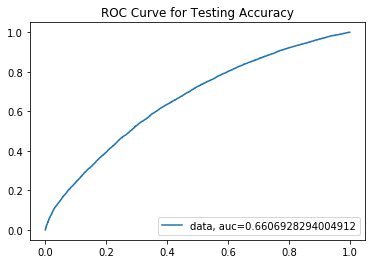

In [48]:
from sklearn import metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve for Testing Accuracy")
plt.show()

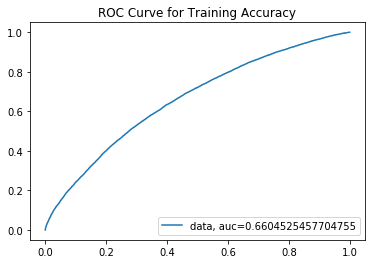

In [49]:
y_pred_proba = lr.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve for Training Accuracy")
plt.show()

In [59]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [2,4,5,6,7,8,10]
gini_score = []
entropy_score = []
for d in max_depth:
    clf_gini = DecisionTreeClassifier(max_depth = d)
    clf_gini = clf_gini.fit(X_train, Y_train)
    gini_score.append(clf_gini.score(X_test,Y_test))
    clf_ig = DecisionTreeClassifier(max_depth = d,criterion = "entropy")
    clf_ig = clf_ig.fit(X_train,Y_train)
    entropy_score.append(clf_ig.score(X_test,Y_test))
gini_score,entropy_score

([0.6169070200511022,
  0.621800701572041,
  0.6216707808236975,
  0.6211944047464381,
  0.6233597505521632,
  0.61448183274869,
  0.6125763284396518],
 [0.6169070200511022,
  0.6215841669914686,
  0.62102117708198,
  0.620501494088606,
  0.6192022866051708,
  0.6175133168767052,
  0.6201983456758045])

In [60]:
from sklearn import tree
clf_ig = DecisionTreeClassifier(max_depth = 7)
clf_ig = clf_ig.fit(X_train, Y_train)



In [64]:
y_pred = clf_ig.predict(X_test)
metrics.accuracy_score(y_pred,Y_test)
confusion_matrix(Y_test,y_pred)

array([[11914,  1791],
       [ 6906,  2480]])

                               Feature  Importance
86      max_glu_serum_greater_than_300    0.003938
2                     time_in_hospital    0.005108
67   diag_3_CIRCULATORY_SYSTEM_DISEASE    0.005123
36         diag_1_ENDO_NUTRI_METABOLIC    0.006468
96                 admission_type_id_3    0.010181
4                       num_procedures    0.010664
116        discharge_disposition_id_22    0.015263
10                           metformin    0.016922
5                      num_medications    0.018507
127              admission_source_id_7    0.026705
124              admission_source_id_4    0.027768
99                 admission_type_id_6    0.029429
3                   num_lab_procedures    0.030296
50   diag_2_CIRCULATORY_SYSTEM_DISEASE    0.039169
7                     number_emergency    0.039499
32                         diabetesMed    0.049534
6                    number_outpatient    0.058837
1                                  age    0.065908
9                     number_di

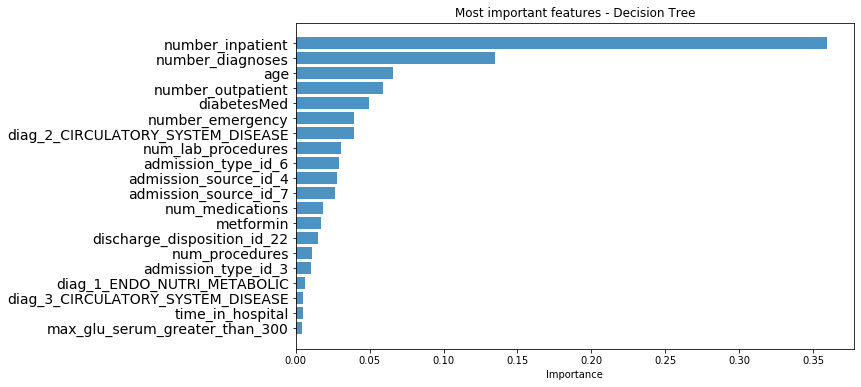

In [56]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = clf_ig.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(20, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [169]:
imp_list = list(newimp.keys())

df_imp = df_2[np.intersect1d(df_2.columns, imp_list)]
df_imp.to_csv("~/Desktop/imp_data.csv",index = False)

NameError: name 'newimp' is not defined

In [779]:
pred_list = clf_ig.predict(X_train)
metrics.accuracy_score(pred_list,Y_train)

0.6298342541436464

In [780]:
test_pred = clf_ig.predict(X_test)
metrics.accuracy_score(test_pred,Y_test)
#test_pred = clf_ig.predict_proba(X_test)
#test_pred

0.6234030574682777

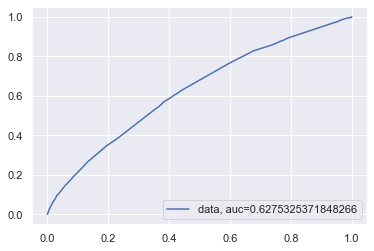

In [781]:
from sklearn import metrics
y_pred_proba = clf_ig.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[Text(379.52205882352945, 764.4375, 'number_inpatient <= 0.5\nentropy = 0.483\nsamples = 46879\nvalue = [27766, 19113]\nclass = y[0]'),
 Text(198.99264705882354, 662.5125, 'number_diagnoses <= 6.5\nentropy = 0.472\nsamples = 41424\nvalue = [25614, 15810]\nclass = y[0]'),
 Text(102.57352941176471, 560.5875, 'admission_type_id_6 <= 0.5\nentropy = 0.433\nsamples = 14921\nvalue = [10192, 4729]\nclass = y[0]'),
 Text(52.517647058823535, 458.66249999999997, 'admission_source_id_7 <= 0.5\nentropy = 0.425\nsamples = 13820\nvalue = [9581, 4239]\nclass = y[0]'),
 Text(26.258823529411767, 356.7375, 'number_outpatient <= 0.5\nentropy = 0.4\nsamples = 7702\nvalue = [5577, 2125]\nclass = y[0]'),
 Text(13.129411764705884, 254.8125, 'admission_source_id_4 <= 0.5\nentropy = 0.39\nsamples = 6901\nvalue = [5067, 1834]\nclass = y[0]'),
 Text(6.564705882352942, 152.88750000000005, 'discharge_disposition_id_22 <= 0.5\nentropy = 0.397\nsamples = 6379\nvalue = [4634, 1745]\nclass = y[0]'),
 Text(3.28235294117

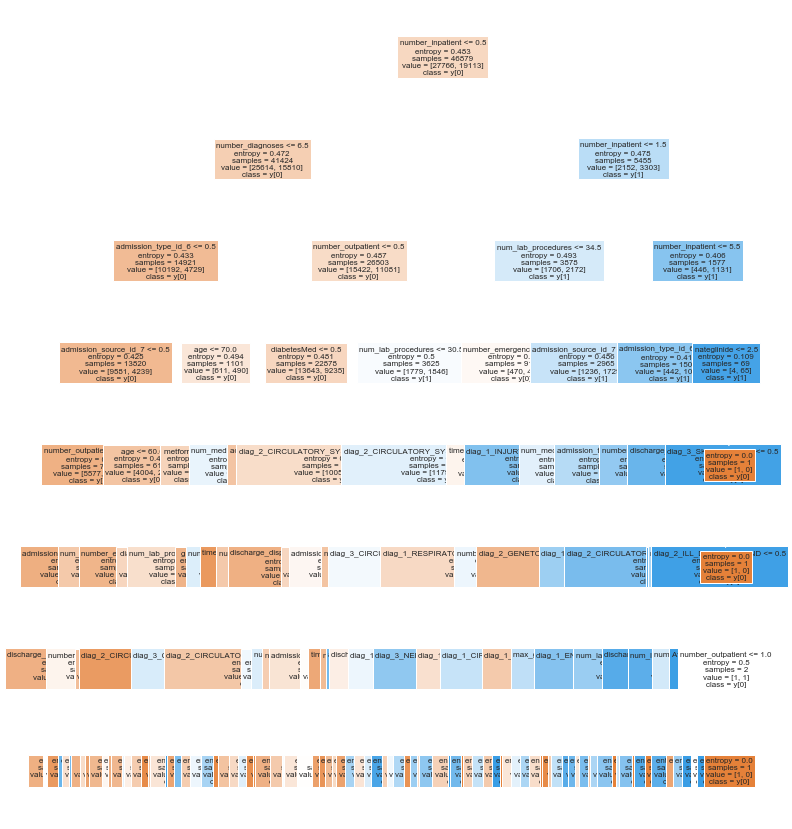

In [624]:
fig, ax = plt.subplots(figsize=(12,15))
tree.plot_tree(clf_ig,max_depth = 7, filled = True,fontsize = 8,feature_names = X_train.columns, class_names = True,ax=ax)


Text(0.5, 1.0, 'Age VS. Readmission')

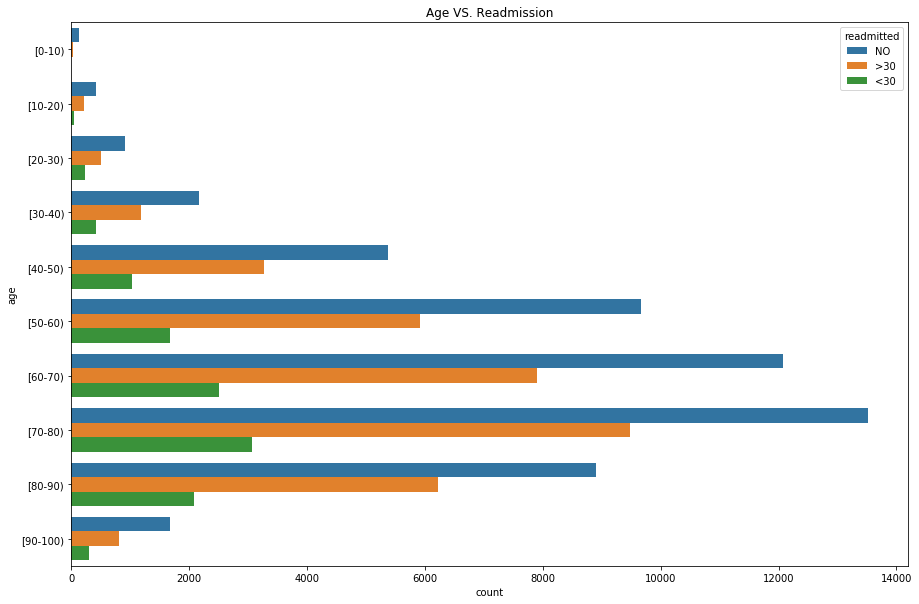

In [6]:
import seaborn as sns
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['age'], hue = data['readmitted']).set_title('Age VS. Readmission')

Text(0.5, 1.0, 'Discharge Dosposition VS. Readmission')

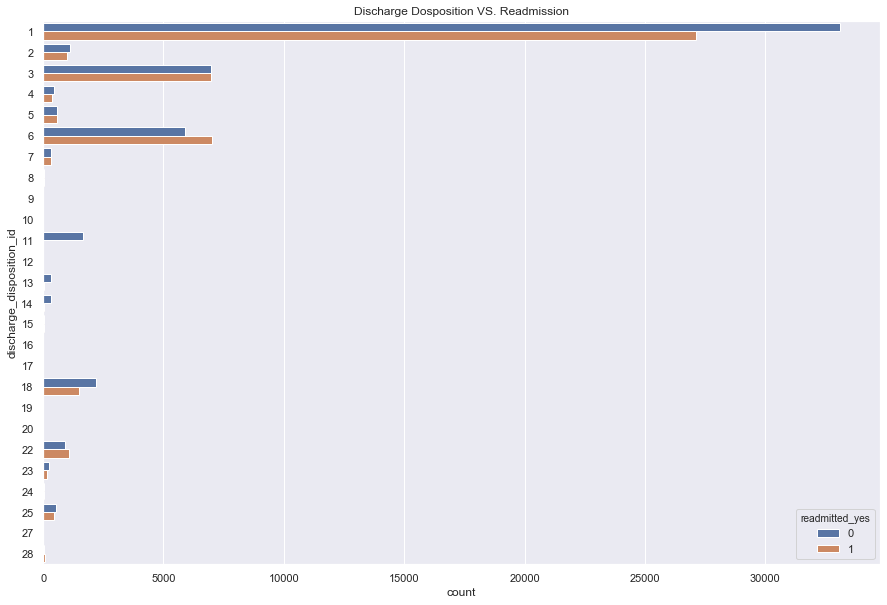

In [626]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['discharge_disposition_id'], hue = data['readmitted_yes']).set_title('Discharge Dosposition VS. Readmission')

Text(0.5, 1.0, 'Gender VS. Readmission')

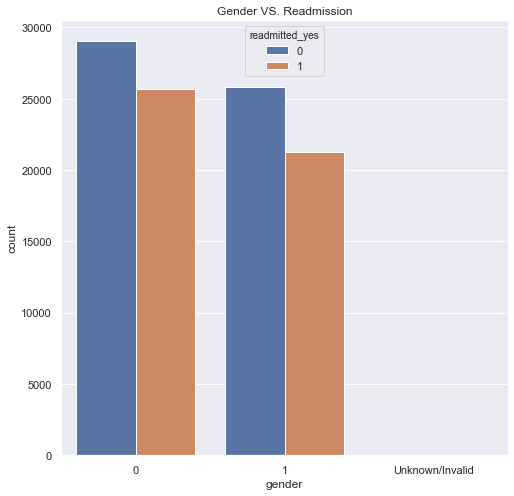

In [625]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['gender'], hue = data['readmitted_yes']).set_title('Gender VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

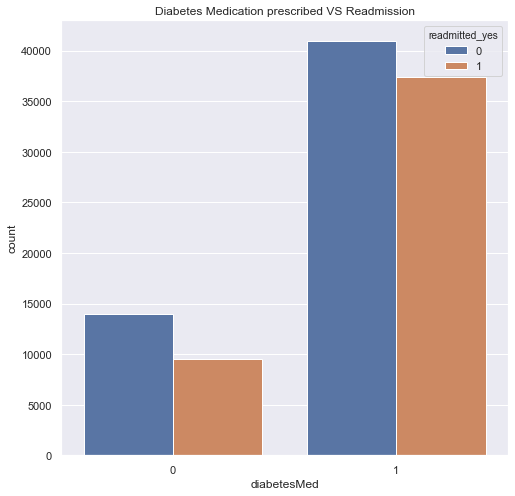

In [627]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['diabetesMed'], hue = data['readmitted_yes']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Admission Source VS Readmission')

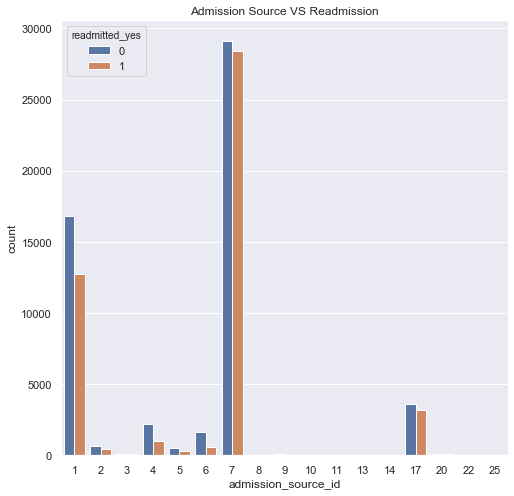

In [628]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['admission_source_id'], hue = data['readmitted_yes']).set_title('Admission Source VS Readmission')

Text(0.5, 1.0, 'Inpatient VS. Readmission')

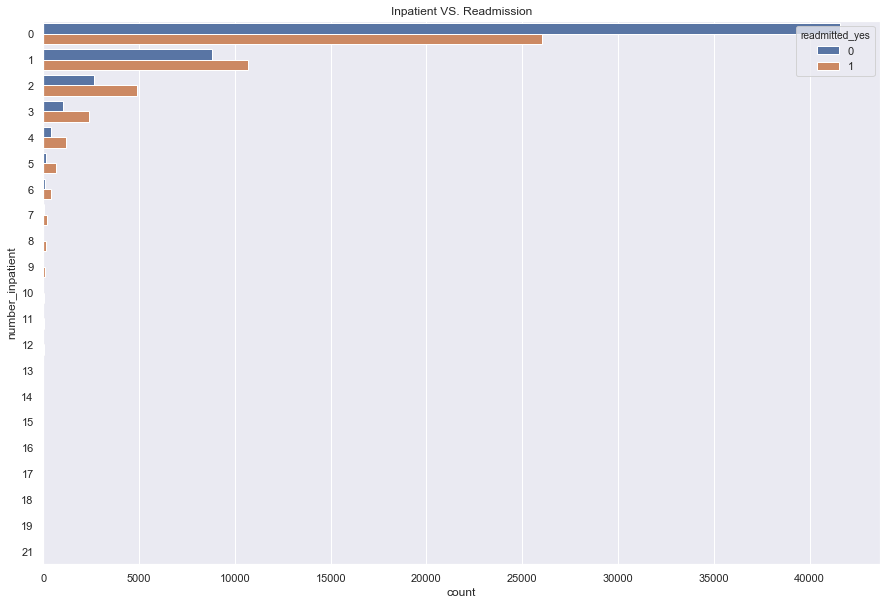

In [629]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['number_inpatient'], hue = data['readmitted_yes']).set_title('Inpatient VS. Readmission')

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,60-70,70-80,80-90,80-90,60-70,70-80,80-90,70-80,80-90,70-80
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
